# Tucker Decomposition
This decomposition aims to dins a core matrix and factor matrices that approximate to the given tensor:

$X \approx G \times U_s \times U_t \times U_p$, 

where:
- $G$: Core matrix.
- $U_s$: Factor matrix corresponding to the **TCR sequences** dimension.
- $U_t$: Factor matrix corresponding to the **time** dimension. 
- $U_p$: Factor matrix corresponding to the **patients** dimension. 


## Imports

### Import General Libraries

In [134]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorly as tl

# Ensure all rows and columns are displayed
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', 1000)  # Adjust width to prevent line breaks
pd.set_option('display.max_colwidth', None)  # Prevent truncation of cell content

### Import tensors
We don't need to convert to tensorly tensor as the numpy tensor already works (and give same results).

In [135]:
tensor_70 = np.load('tensors/tensor_70.npy')
tensor_100 = np.load('tensors/tensor_100.npy')
tensor_200 = np.load('tensors/tensor_200.npy')
tensor_300 = np.load('tensors/tensor_300.npy')

# tensor_200 = tl.tensor(tensor_200)

# we create a list with the tensors for more efficient coding
tensors = [tensor_70, tensor_100, tensor_200, tensor_300]
tensor_names = ['70', '100', '200', '300']

## Choose ranks
We run SVD in each dim to find the suitable number of ranks for the decomposition. We try several thresholds and we plot the results to find the elbow (and the appropriate number of ranks). These ranks are shared among the different applications of Tucker decomposition.

In [136]:
from scipy.linalg import svd
from kneed import KneeLocator  # For automatic elbow detection

# Function to compute the rank selection using SVD and plot variance retention
def compute_svd_ranks_elbow(tensor, tensor_name, threshold=0.75):
    """
    Computes the optimal rank for each mode using SVD and selects the rank 
    using both the variance threshold and elbow method. Plots all three modes 
    in a single figure for better visualization.

    Parameters:
    tensor (np.array): The input tensor
    tensor_name (str): The name of the tensor (for labeling plots)
    threshold (float): The percentage of variance to retain when choosing ranks

    Returns:
    ranks_elbow (list): Selected ranks using elbow method
    """
    ranks_threshold = []
    ranks_elbow = []

    # Create a single figure with 3 subplots (one for each mode)
    fig, axes = plt.subplots(1, 3, figsize=(17, 5))
    fig.suptitle(f"Explained Variance for tensor_{tensor_name}", fontsize=14)

    for mode in range(tl.ndim(tensor)):
        # Matricize tensor along the mode
        matricized = tl.unfold(tensor, mode)
        U, S, Vt = svd(matricized, full_matrices=False)

        # Compute cumulative explained variance
        cumulative_variance = np.cumsum(S**2) / np.sum(S**2)

        # Select rank based on variance threshold
        selected_rank_threshold = np.searchsorted(cumulative_variance, threshold) + 1
        ranks_threshold.append(selected_rank_threshold)

        # Elbow Method: Automatically detect the best rank
        elbow_locator = KneeLocator(np.arange(1, len(S)+1), cumulative_variance, curve="concave", direction="increasing")
        selected_rank_elbow = elbow_locator.knee if elbow_locator.knee else selected_rank_threshold
        ranks_elbow.append(selected_rank_elbow)

        # Plot on the corresponding subplot
        ax = axes[mode]
        ax.plot(np.arange(1, len(S)+1), cumulative_variance, marker='o', linestyle='-', label='Cumulative Variance')
        # ax.axhline(y=threshold, color='r', linestyle='--', label=f'{threshold*100}% Variance Threshold')
        if selected_rank_elbow:
            ax.axvline(x=selected_rank_elbow, color='r', linestyle='--', label='Elbow')

        # Labels & Title
        ax.set_xlabel("Number of Singular Values Retained")
        ax.set_ylabel("Cumulative Explained Variance")
        ax.set_title(f"Mode {mode}")
        ax.grid()

    # Show a shared legend only once
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper right")

    plt.show()
    
    return ranks_elbow


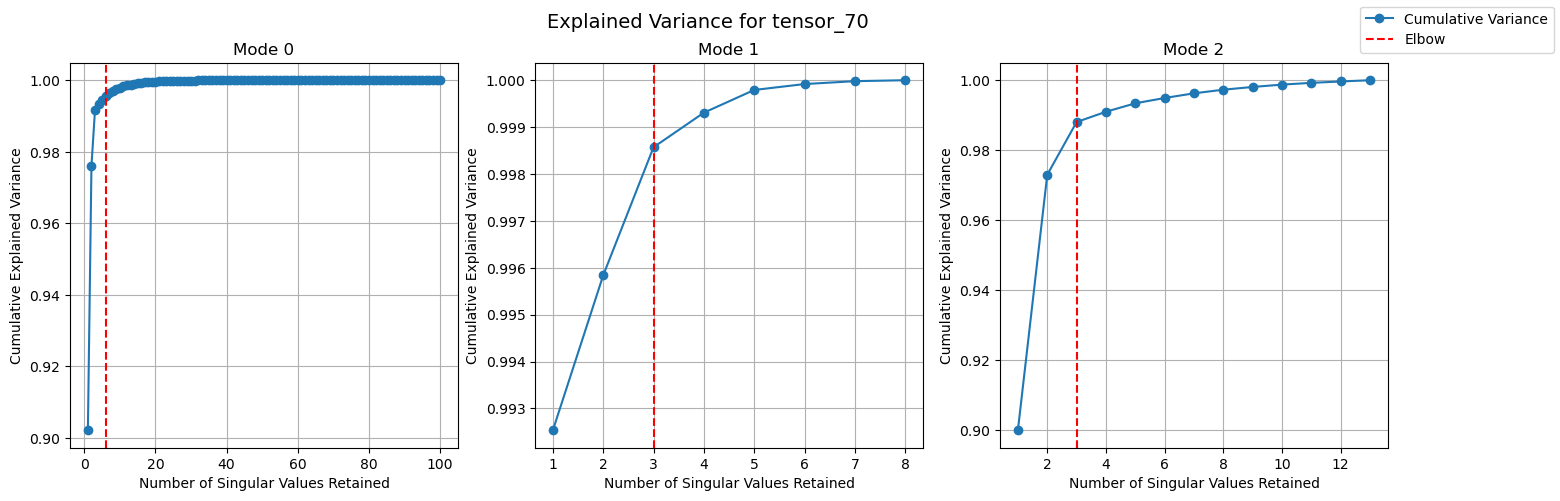

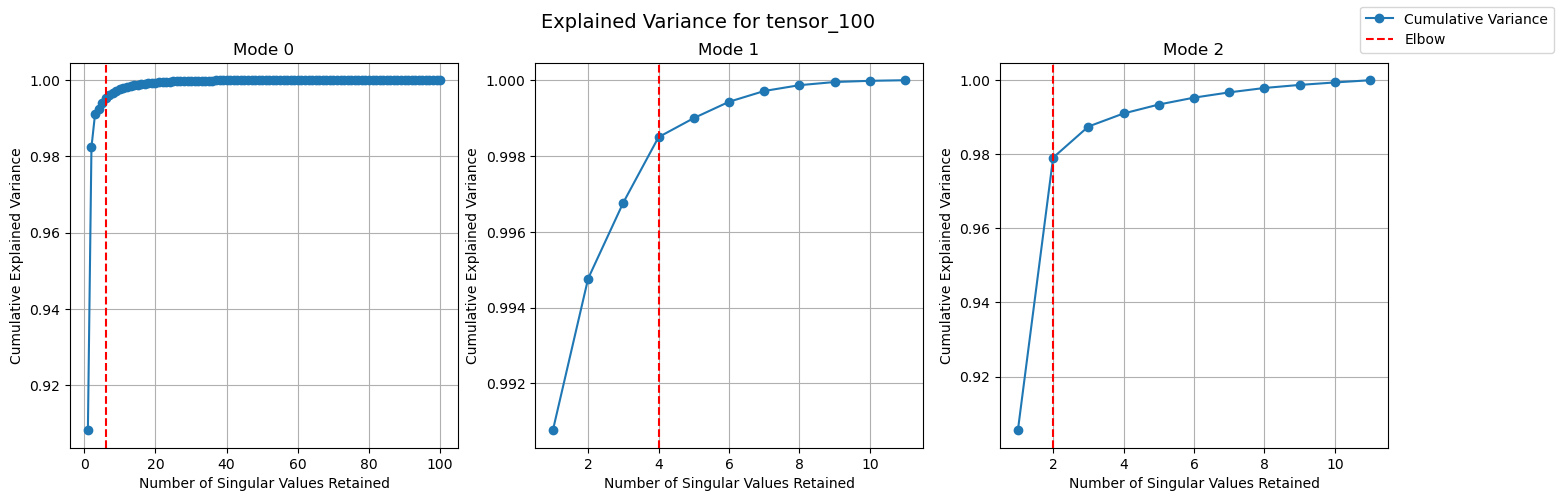

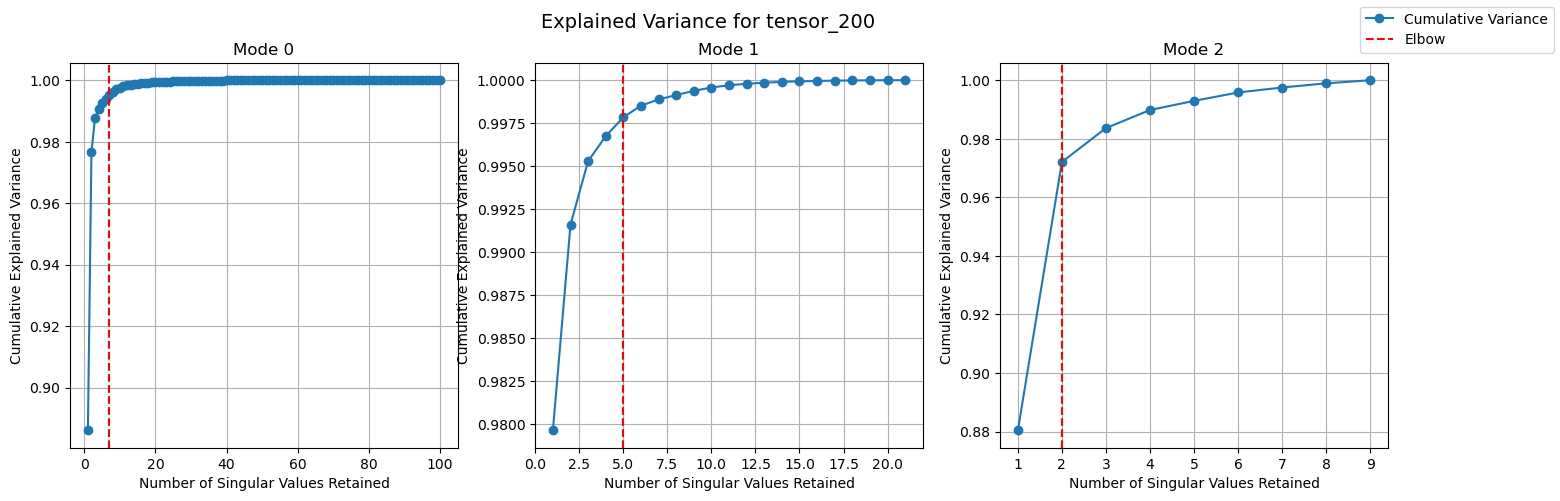

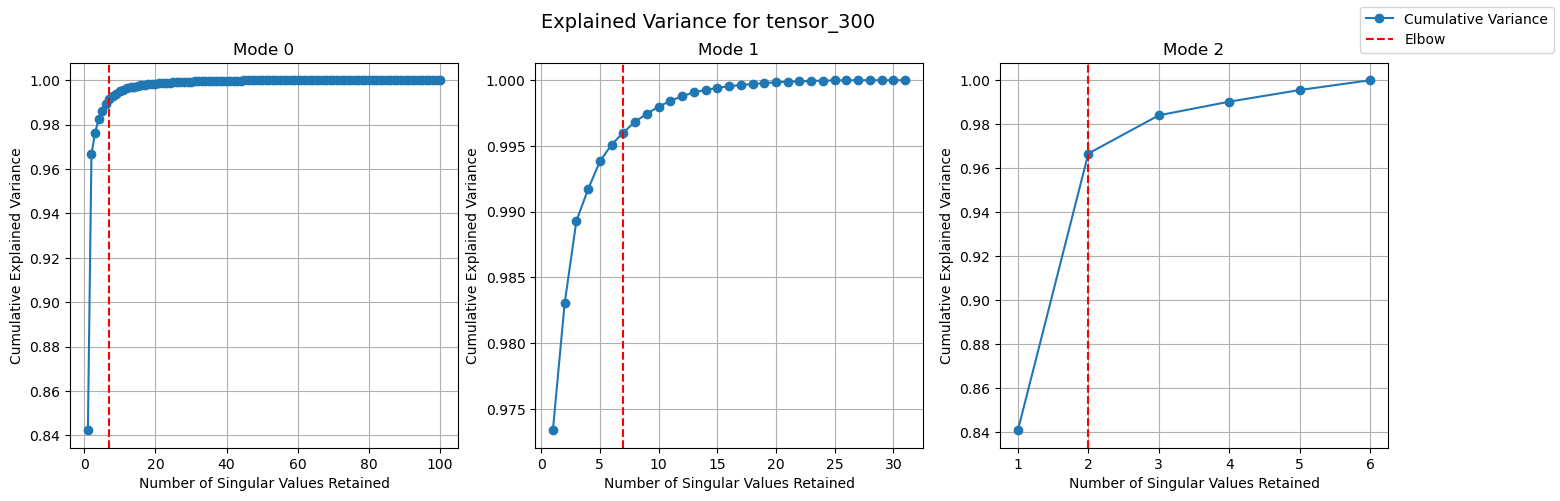


FINAL RANKS:
    Final Ranks for tensor_70: [6, 3, 3]
    Final Ranks for tensor_100: [6, 4, 2]
    Final Ranks for tensor_200: [7, 5, 2]
    Final Ranks for tensor_300: [7, 7, 2]


In [137]:
# Run for all our tensors
final_ranks = []  # List to store ranks using elbow method

for i, tensor in enumerate(tensors):
    tensor_name = tensor_names[i]  # To label the tensor (e.g., time 70, 100, 200, 300)

    # Compute ranks using SVD with both threshold and elbow methods
    selected_ranks_elbow = compute_svd_ranks_elbow(tensor, tensor_name, threshold=0.9)

    final_ranks.append(selected_ranks_elbow)

# Print final ranks
print('\nFINAL RANKS:')
for i, tensor in enumerate(tensors):
    print(f"    Final Ranks for tensor_{tensor_names[i]}: {final_ranks[i]}")

## Decompositions
Three different analysis can be done with Tucker: exploratory analysis (to find hidden patterns), clustering (to find groupings), and classification (to classify new data).

### Exploratory analysis
We start with exploratory analysis to find hidden patterns. To have better interpretability, we use HALS-NTS algorithm to ensure that the non-negativity constraint is applied and hence, yield to more interpretable results (as they have biological meaning). Also, thi salgorithm refines the result iteratively.


#### Decomposition

In [138]:
import numpy as np
import tensorly as tl
from tensorly.decomposition import non_negative_tucker_hals  # HALS-NTD

# Dictionary to store results
tucker_results = {}

# Loop over all tensors and apply HALS-NTD Tucker decomposition
for i, tensor in enumerate(tensors):
    tensor_name = tensor_names[i]
    ranks = tuple(final_ranks[i])  # Ensure ranks are a tuple

    print(f"\nProcessing {tensor_name}: Tensor shape {tensor.shape}, Ranks {ranks}")

    try:
        # Convert tensor to TensorLy tensor
        tensor = tl.tensor(tensor)

        # Apply HALS-NTD Tucker decomposition
        core, factors = non_negative_tucker_hals(tensor, rank=ranks, n_iter_max=100, tol=1e-6)

        # Store results
        tucker_results[tensor_name] = {
            "core_tensor": core,
            "factor_matrices": factors
        }

        print(f"    tensor_{tensor_name} decomp shapes:")
        print(f"        core: {core.shape}")
        print(f"        Us: {factors[0].shape}")
        print(f"        Ut {factors[1].shape}")
        print(f"        Up {factors[2].shape}")
    except ValueError as e:
        print(f"Error in decomposition for {tensor_name}: {e}")



Processing 70: Tensor shape (100, 8, 13), Ranks (6, 3, 3)
    tensor_70 decomp shapes:
        core: (6, 3, 3)
        Us: (100, 6)
        Ut (8, 3)
        Up (13, 3)

Processing 100: Tensor shape (100, 11, 11), Ranks (6, 4, 2)
    tensor_100 decomp shapes:
        core: (6, 4, 2)
        Us: (100, 6)
        Ut (11, 4)
        Up (11, 2)

Processing 200: Tensor shape (100, 21, 9), Ranks (7, 5, 2)
    tensor_200 decomp shapes:
        core: (7, 5, 2)
        Us: (100, 7)
        Ut (21, 5)
        Up (9, 2)

Processing 300: Tensor shape (100, 31, 6), Ranks (7, 7, 2)
    tensor_300 decomp shapes:
        core: (7, 7, 2)
        Us: (100, 7)
        Ut (31, 7)
        Up (6, 2)


#### Visualization
We can visualise 4 different plots, one for each core and factor matrices from the decomposition. 
- `factors[0]` $ = U_s$: Factor matrix corresponding to the **TCR sequences** dimension. Can be visualised using heatmaps.
- `factors[1]` $ = U_t$: Factor matrix corresponding to the **time** dimension. Can be visualised using timeseries.
- `factors[2]` $ = U_p$: Factor matrix corresponding to the **patients** dimension. Can be visualised using clustering techniques.
- `core` $ = G$: Core matrix. Can be visualised using slice-wise heatmaps.

In [139]:
def plot_factor_matrix_heatmap(factor_matrix, column_labels=None, row_labels=None, y_label=None, x_label=None, title="Factor Matrix Heatmap"):
    plt.figure(figsize=(12, 6))

    ax = sns.heatmap(factor_matrix, cmap="jet", cbar=True, linewidths=0.5)

    # Label rows and columns
    if column_labels:
        ax.set_xticks(np.arange(len(column_labels)) + 0.5)
        ax.set_xticklabels(column_labels, rotation=90)
    else:
        ax.set_xticks([])

    if row_labels:
        ax.set_yticks(np.arange(len(row_labels)) + 0.5)
        ax.set_yticklabels(row_labels,rotation=45)
    else:
        ax.set_yticks([])

    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()


In [140]:
def plot_factor_matrix_timeseries(factor_matrix, y_label=None, x_label='Time (Days)', title="Factor Matrix Timeseries", step=10):
    """
    Plots the factor matrix as multiple time series, one per rank.

    Parameters:
    - factor_matrix (np.array): The factor matrix (time x ranks).
    - y_label (str): Label for y-axis (optional).
    - x_label (str): Label for x-axis.
    - title (str): Title of the plot.
    - step (int): Step size for x-axis ticks (default is 10).
    """
    # Find number of ranks
    ranks = factor_matrix.shape[1]    
    fig, ax = plt.subplots(ranks, 1, figsize=(12, 8), sharex=True)  # Share x-axis for better alignment

    # Define correct x-axis values (time steps)
    time_steps = np.arange(0, factor_matrix.shape[0] * step, step)  

    for i in range(ranks):
        ax[i].plot(time_steps, factor_matrix[:, i])  # Plot using time_steps
        ax[i].set_ylabel(f'Rank {i+1}')

    # Set x-ticks at correct intervals
    ax[-1].set_xticks(time_steps)
    ax[-1].set_xticklabels(time_steps)  # Ensure labels match tick positions

    # Set labels and title
    ax[-1].set_xlabel(x_label)
    plt.suptitle(title)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


In [141]:
def plot_core_tensor_slices(core_tensor, slice_axis=0, title="Core Tensor Slices"):
    """
    Plots slice-wise heatmaps of the core tensor along a specified axis.

    Parameters:
    - core_tensor (np.array): The core tensor from Tucker decomposition.
    - slice_axis (int): The axis along which to slice (0, 1, or 2).
    - title (str): Title of the figure.
    """
    num_slices = core_tensor.shape[slice_axis]  # Number of slices along the chosen axis

    fig, axes = plt.subplots(1, num_slices, figsize=(15, 5))
    fig.suptitle(title, fontsize=14)

    # Iterate over slices along the specified axis
    for i in range(num_slices):
        if slice_axis == 0:
            slice_data = core_tensor[i, :, :]  # Fix first dimension, vary last two
            slice_title = f"Slice {i+1} (Mode 0)"
        elif slice_axis == 1:
            slice_data = core_tensor[:, i, :]  # Fix second dimension
            slice_title = f"Slice {i+1} (Mode 1)"
        else:
            slice_data = core_tensor[:, :, i]  # Fix third dimension
            slice_title = f"Slice {i+1} (Mode 2)"

        ax = axes[i] if num_slices > 1 else axes
        sns.heatmap(slice_data, cmap="jet", cbar=True, ax=ax)
        ax.set_title(slice_title)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


In [142]:
# Core matrix - find most relevant
from itertools import product
def most_relevant(core_tensor):
    # Extract core tensor from decomposition results
    # core_tensor_values = tucker_results[tensor_nm]["core_tensor"]  # Replace with your tensor key

    # Convert core tensor to a DataFrame with meaningful statistics
    core_tensor_df = pd.DataFrame({
        "Index": list(product(*[np.arange(1, si+1) for si in core_tensor.shape])),  # Tuple index
        "Weight": core_tensor.flatten(),  # Raw core tensor values
        "Fraction": core_tensor.flatten()**2,  # Energy contribution
        "Sign": np.sign(core_tensor.flatten())  # Positive or negative value
    })

    # Normalize Fraction to sum to 1 (percentage of importance)
    core_tensor_df["Fraction"] /= core_tensor_df["Fraction"].sum()

    # Convert index tuples to string for better visualization
    core_tensor_df["Index"] = core_tensor_df["Index"].astype(str)

    # Sort by Fraction (importance) in descending order
    core_tensor_df = core_tensor_df.sort_values("Fraction", ascending=False)

    return core_tensor_df 


    # # Display the DataFrame
    # import ace_tools as tools
    # tools.display_dataframe_to_user(name="Core Tensor Analysis", dataframe=core_tensor_df)


# core_tensor = pd.DataFrame({
#                        "Index": product(*[np.arange(1, si+1) for si in tres[0].shape]),
#                         "Weight": tres[0].flatten(),
#                         "Fraction": tres[0].flatten()**2,
#                         "Sign": np.sign(tres[0].flatten()),
#                     })

# core_tensor = core_tensor.sort_values("Fraction", ascending=False)
# core_tensor["Index"] = core_tensor["Index"].astype(str)
# core_tensor["Fraction"] = core_tensor["Fraction"] / np.sum(core_tensor["Fraction"])
# core_tensor

In [143]:
def decomp_visualizations(td_dic,t_name,pat_list):
    core = td_dic['core_tensor']
    factors = td_dic['factor_matrices']
    Us = factors[0]  
    Ut = factors[1]
    Up = factors[2]
    # Us - 1 figure
    column_labels = [f"Rank {i+1}" for i in range(Us.shape[1])]
    row_labels = [f"{i+1}" for i in range(Us.shape[0])]
    y_label = 'Sequences'
    plot_factor_matrix_heatmap(Us, column_labels=column_labels, y_label=y_label,title=f"Us Heatmap for tensor_{t_name}")

    # Ut - 1 figure: 1 rank 1 subplot or all ranks 1 subplot
    plot_factor_matrix_timeseries(Ut,title=f"Ut Timeseries for tensor_{t_name}")

    # Up - 1 figure
    y_label = 'Patients'
    column_labels = [f"Rank {i+1}" for i in range(Up.shape[1])]
    row_labels = [f"{pat_list[i]}" for i in range(Up.shape[0])]
    plot_factor_matrix_heatmap(Up, column_labels=column_labels,row_labels=row_labels, y_label=y_label,title=f"Up Heatmap for tensor_{t_name}")

    # Core matrix - 1 figure, each slice is 1 subplot
    plot_core_tensor_slices(core, slice_axis=0, title=f"Core tensor Heatmaps by slice for tensor_{t_name}")
    plot_core_tensor_slices(core, slice_axis=1, title=f"Core tensor Heatmaps by slice for tensor_{t_name}")
    plot_core_tensor_slices(core, slice_axis=2, title=f"Core tensor Heatmaps by slice for tensor_{t_name}")
    core_tensor_df = most_relevant(core)
    print(core_tensor_df)

##### tensor_70

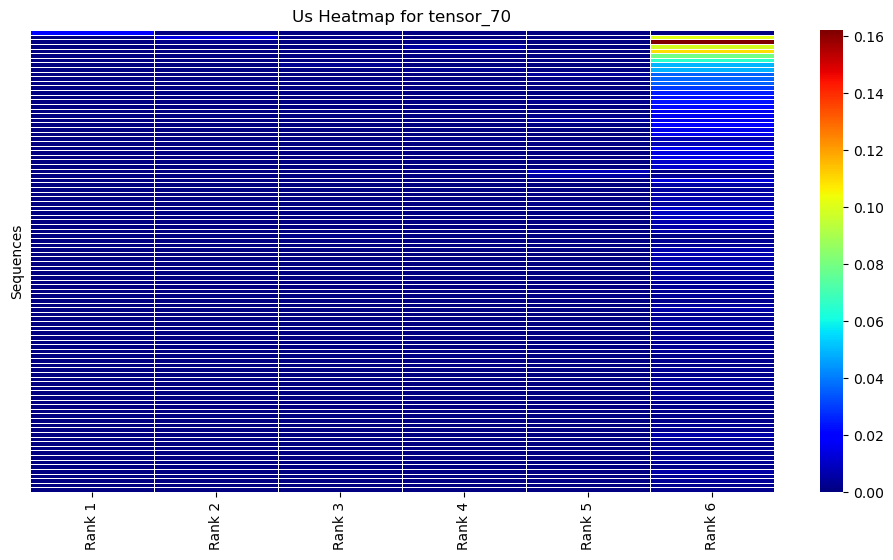

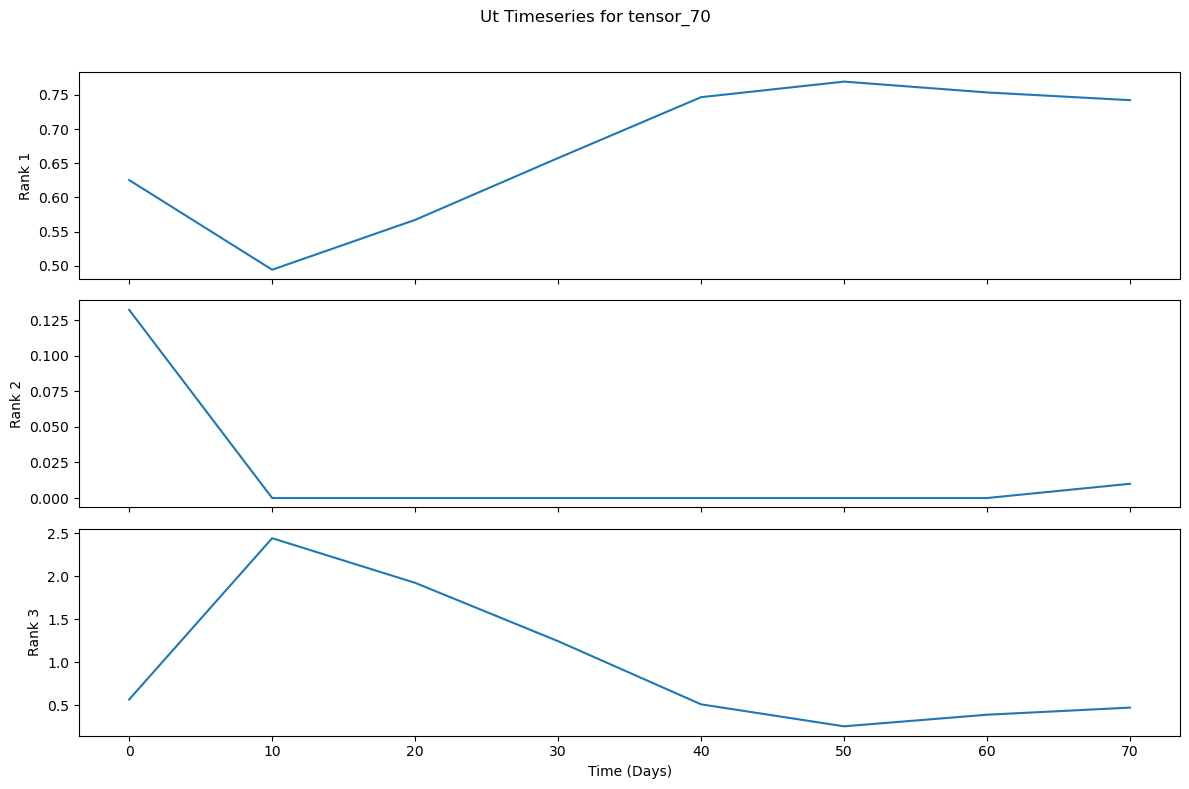

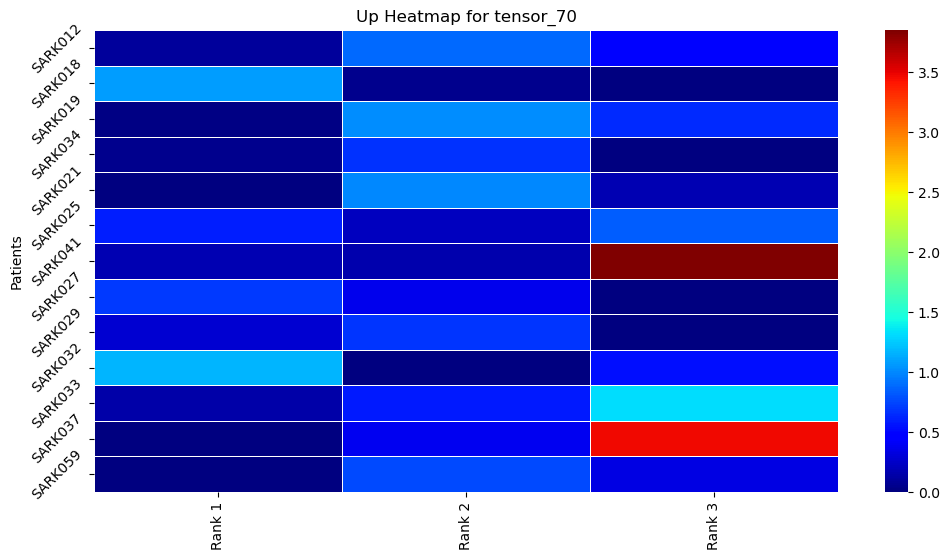

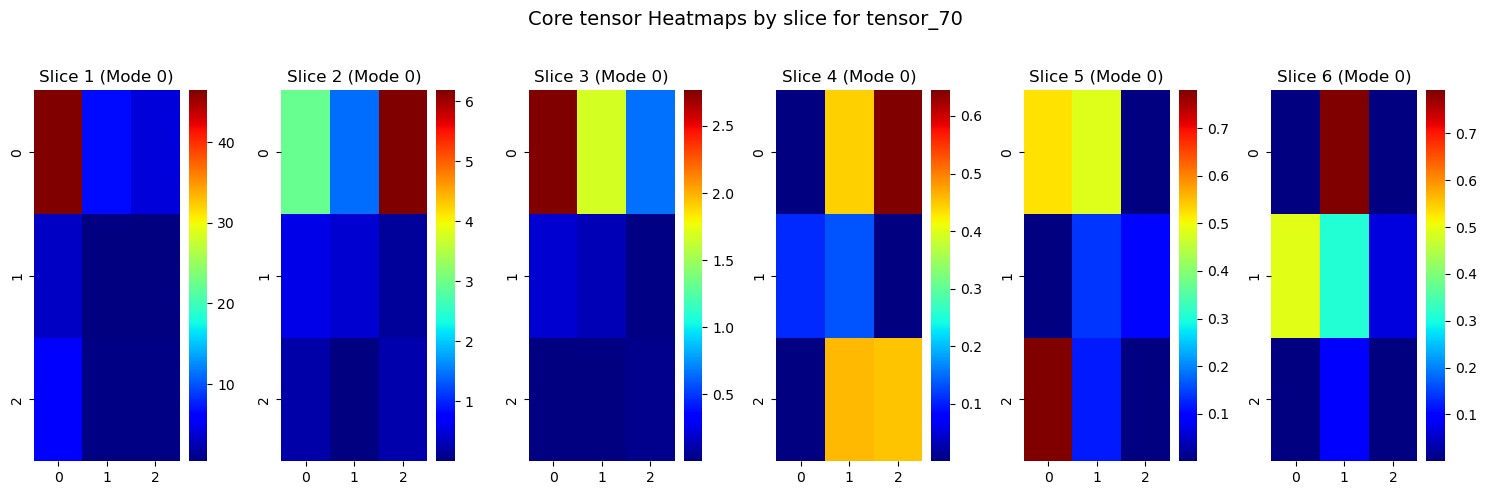

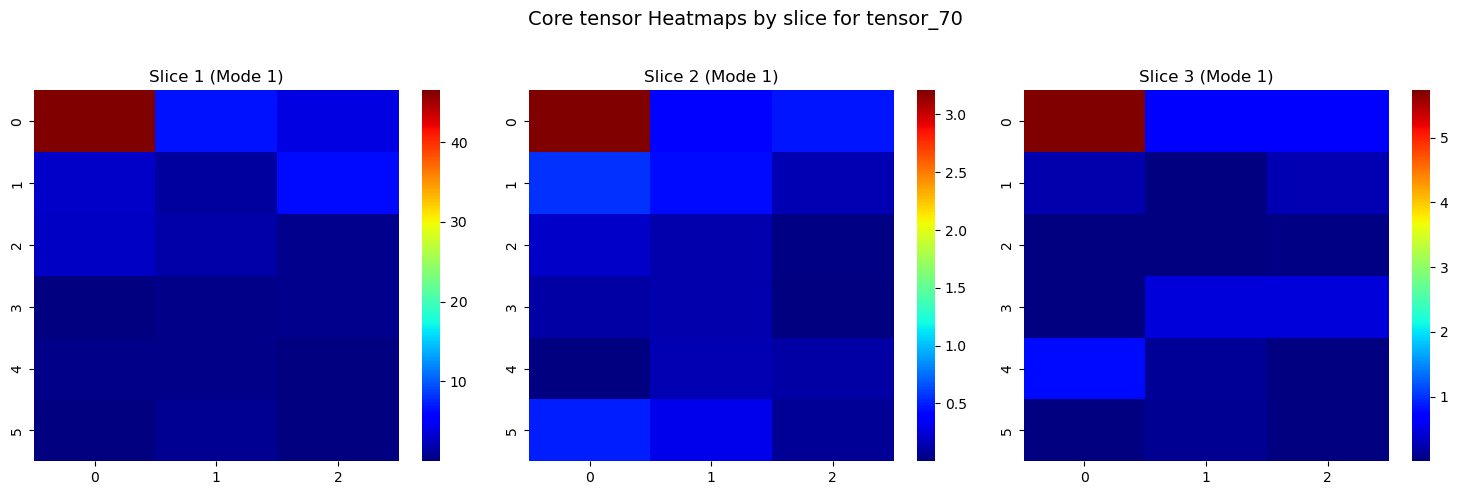

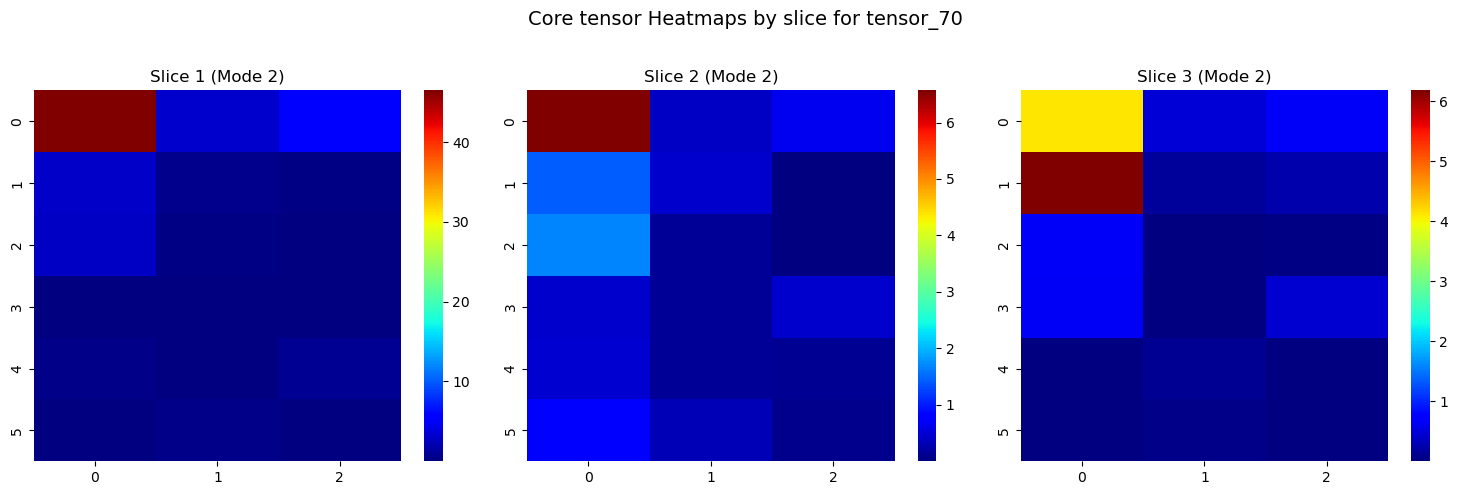

        Index        Weight      Fraction  Sign
0   (1, 1, 1)  4.647411e+01  9.277936e-01   1.0
1   (1, 1, 2)  6.570380e+00  1.854429e-02   1.0
11  (2, 1, 3)  6.181339e+00  1.641324e-02   1.0
6   (1, 3, 1)  5.732325e+00  1.411532e-02   1.0
2   (1, 1, 3)  4.108533e+00  7.251082e-03   1.0
3   (1, 2, 1)  3.207895e+00  4.420479e-03   1.0
9   (2, 1, 1)  2.930303e+00  3.688538e-03   1.0
18  (3, 1, 1)  2.765681e+00  3.285740e-03   1.0
19  (3, 1, 2)  1.679605e+00  1.211835e-03   1.0
10  (2, 1, 2)  1.435090e+00  8.846826e-04   1.0
46  (6, 1, 2)  7.921238e-01  2.695350e-04   1.0
42  (5, 3, 1)  7.795091e-01  2.610186e-04   1.0
8   (1, 3, 3)  6.628126e-01  1.887169e-04   1.0
20  (3, 1, 3)  6.550110e-01  1.843004e-04   1.0
7   (1, 3, 2)  6.450321e-01  1.787276e-04   1.0
29  (4, 1, 3)  6.445759e-01  1.784749e-04   1.0
12  (2, 2, 1)  5.588053e-01  1.341375e-04   1.0
36  (5, 1, 1)  5.223946e-01  1.172267e-04   1.0
48  (6, 2, 1)  4.932773e-01  1.045229e-04   1.0
37  (5, 1, 2)  4.816569e-01  9.965631e-0

In [144]:
i=0 #tensor_70
td_dic = tucker_results[tensor_names[i]]
pat_list = ['SARK012', 'SARK018', 'SARK019', 'SARK034', 'SARK021', 'SARK025', 
                'SARK041', 'SARK027', 'SARK029', 'SARK032', 'SARK033', 'SARK037', 'SARK059']
decomp_visualizations(td_dic,tensor_names[i], pat_list=pat_list)

##### tensor_100

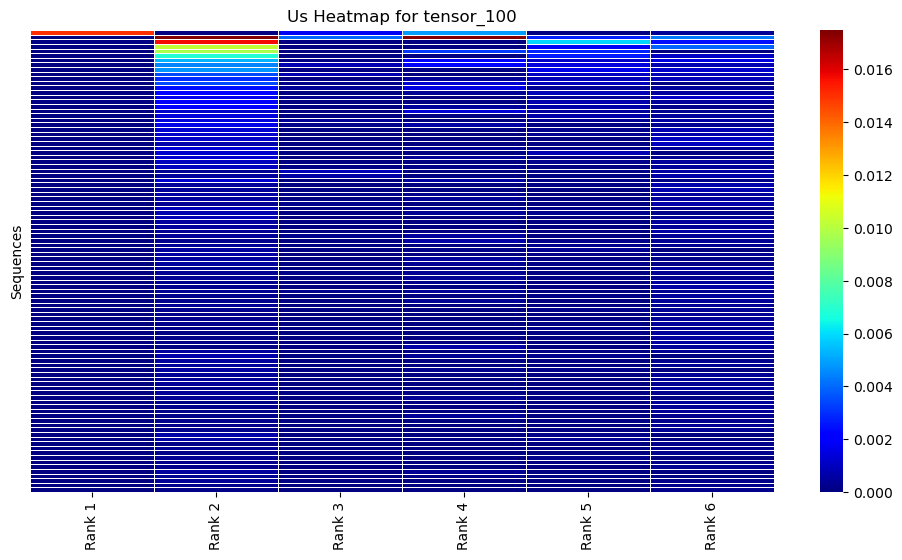

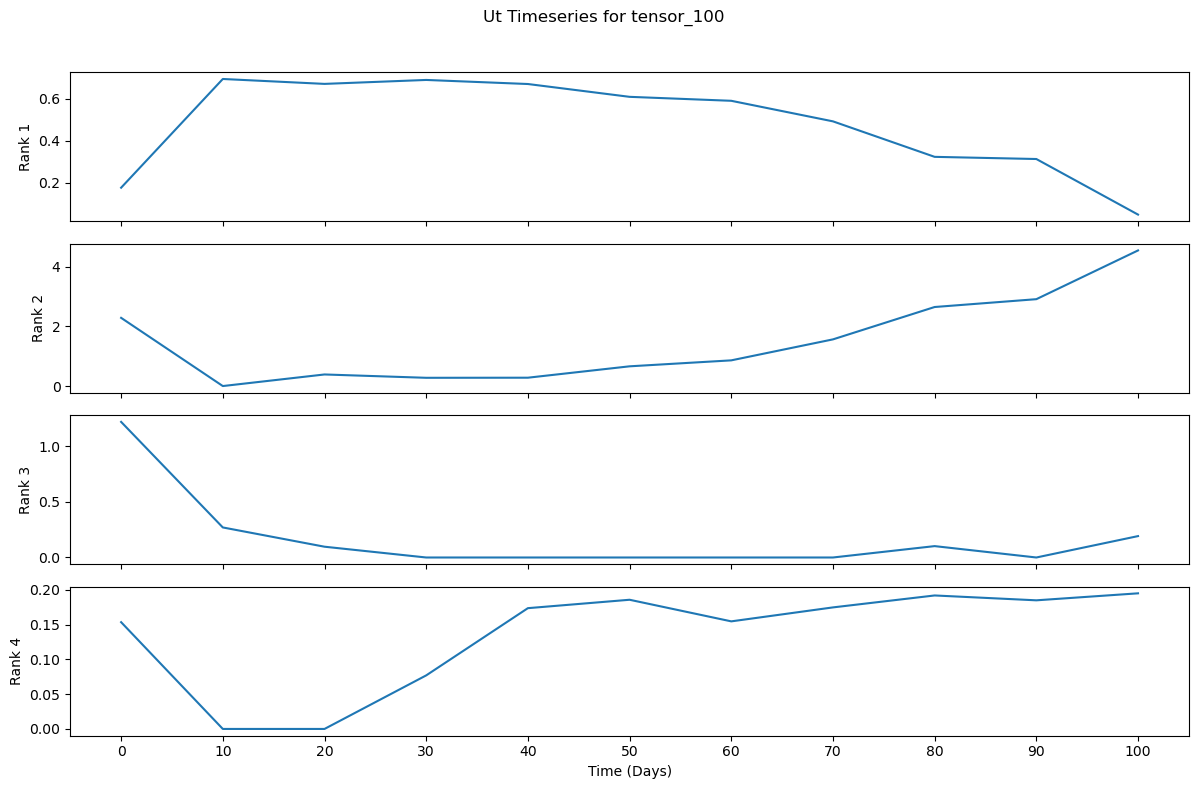

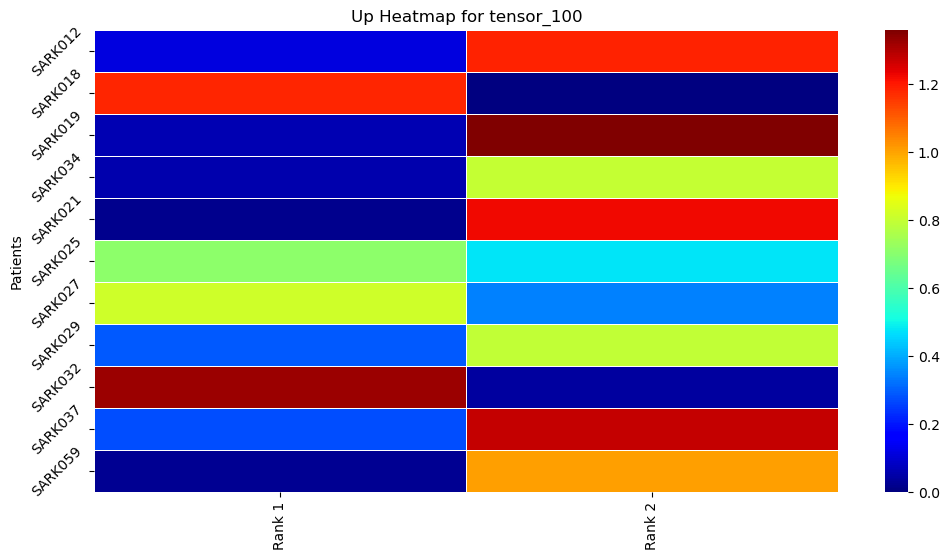

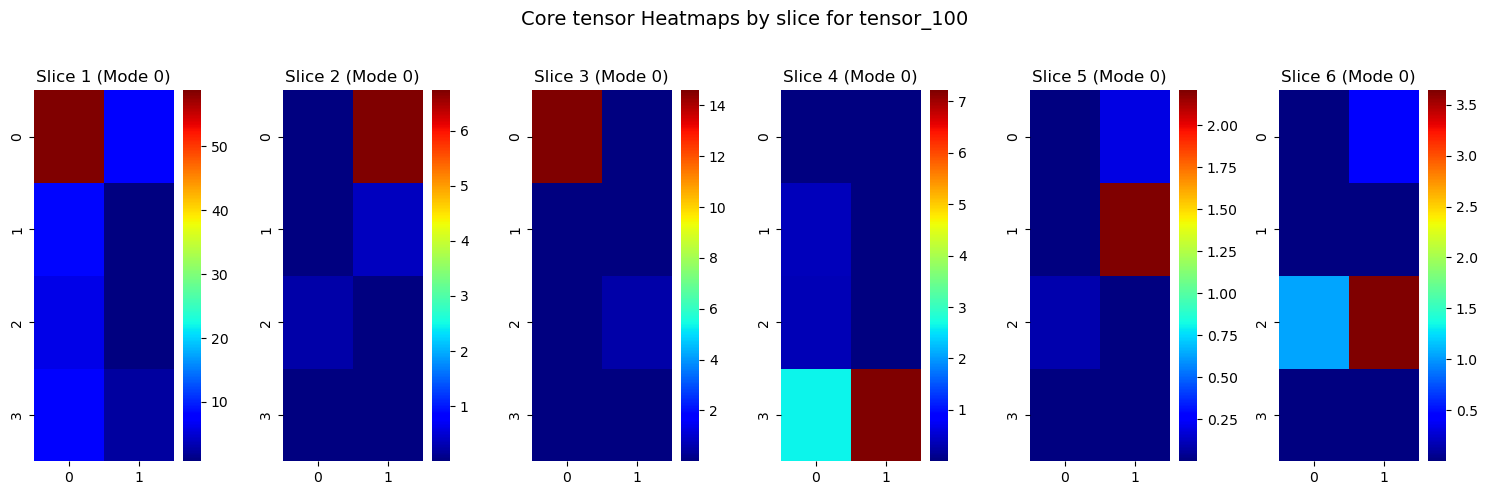

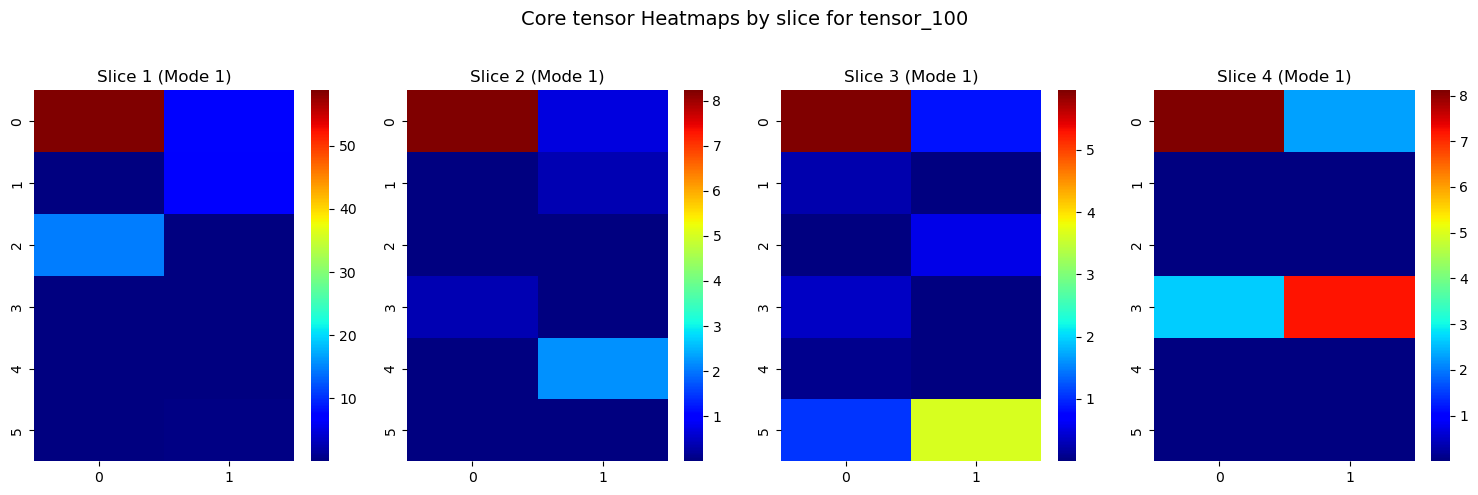

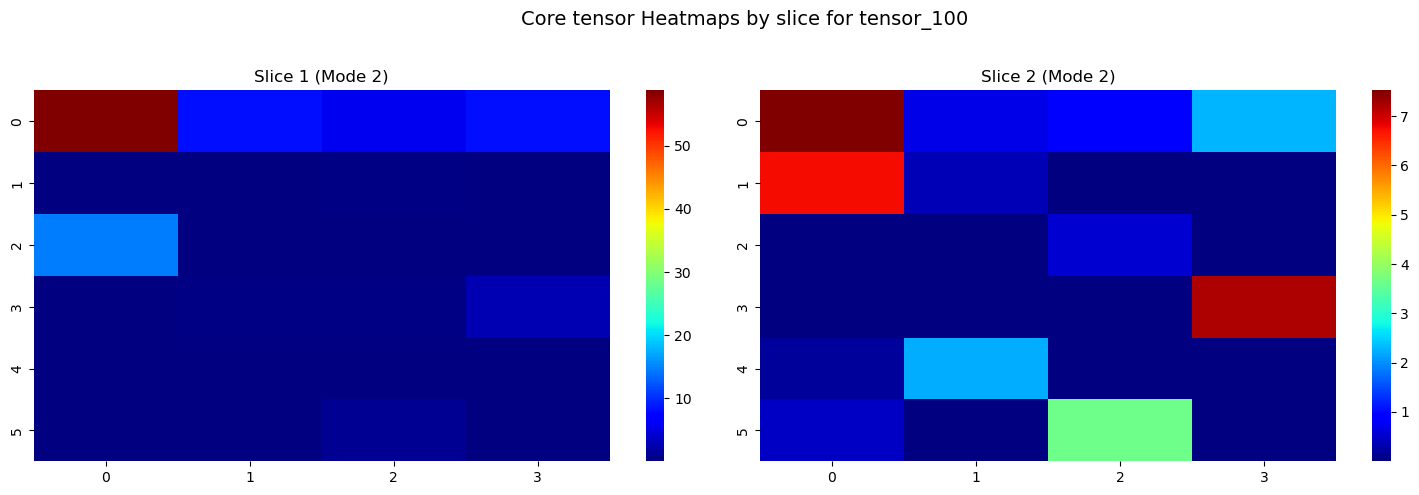

        Index        Weight      Fraction  Sign
0   (1, 1, 1)  5.879479e+01  8.585550e-01   1.0
16  (3, 1, 1)  1.459028e+01  5.287105e-02   1.0
2   (1, 2, 1)  8.228149e+00  1.681492e-02   1.0
6   (1, 4, 1)  8.114324e+00  1.635291e-02   1.0
1   (1, 1, 2)  7.524598e+00  1.406232e-02   1.0
31  (4, 4, 2)  7.214153e+00  1.292591e-02   1.0
9   (2, 1, 2)  6.732450e+00  1.125736e-02   1.0
4   (1, 3, 1)  5.952883e+00  8.801264e-03   1.0
45  (6, 3, 2)  3.640268e+00  3.291221e-03   1.0
30  (4, 4, 1)  2.641820e+00  1.733392e-03   1.0
7   (1, 4, 2)  2.291096e+00  1.303698e-03   1.0
35  (5, 2, 2)  2.206841e+00  1.209574e-03   1.0
44  (6, 3, 1)  1.048085e+00  2.728248e-04   1.0
5   (1, 3, 2)  8.442392e-01  1.770196e-04   1.0
3   (1, 2, 2)  6.942785e-01  1.197175e-04   1.0
21  (3, 3, 2)  5.387607e-01  7.209120e-05   1.0
41  (6, 1, 2)  4.504054e-01  5.038459e-05   1.0
11  (2, 2, 2)  3.736256e-01  3.467079e-05   1.0
26  (4, 2, 1)  3.716593e-01  3.430682e-05   1.0
28  (4, 3, 1)  3.643309e-01  3.296723e-0

In [145]:
i=1 #tensor_100
td_dic = tucker_results[tensor_names[i]]
pat_list = ['SARK012', 'SARK018', 'SARK019', 'SARK034', 'SARK021', 'SARK025', 
                'SARK027', 'SARK029', 'SARK032', 'SARK037', 'SARK059']
decomp_visualizations(td_dic,tensor_names[i], pat_list=pat_list)

##### tensor_200

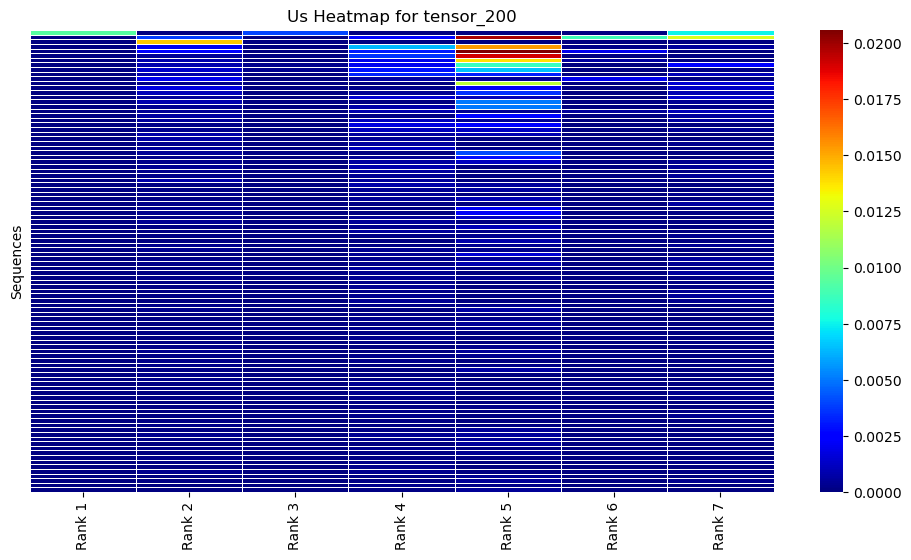

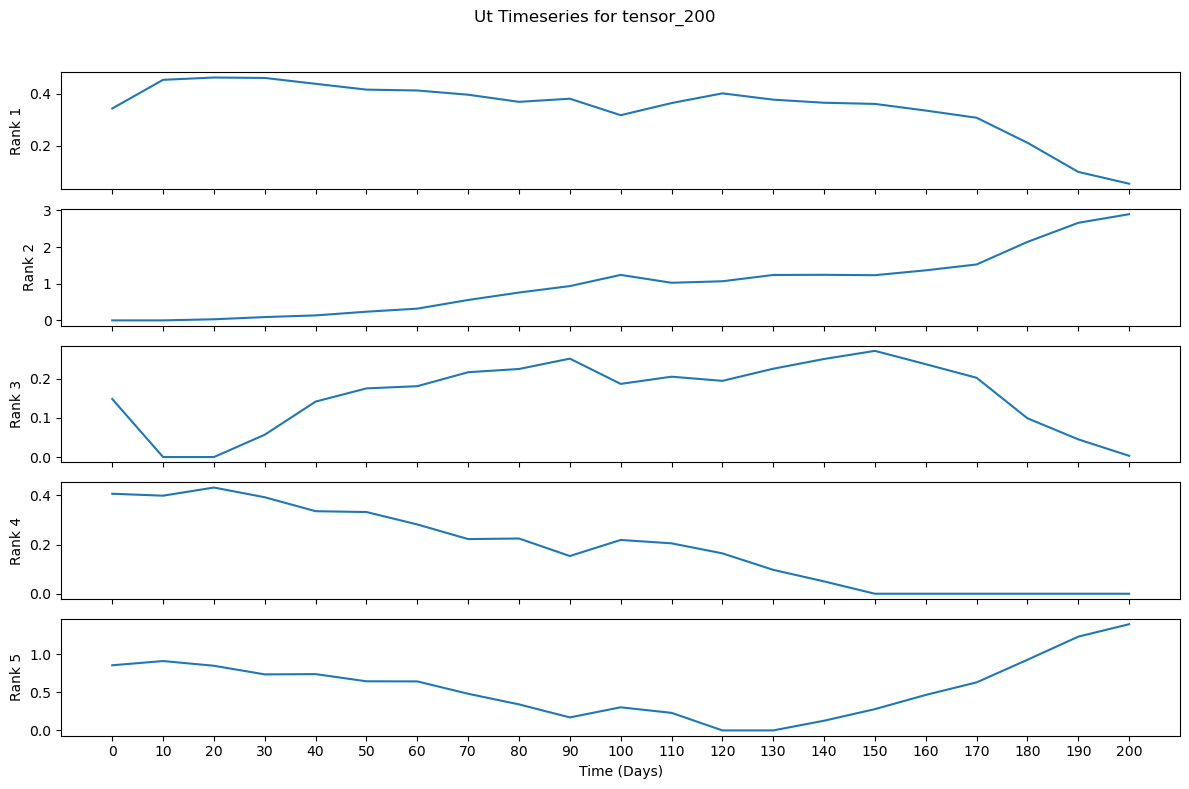

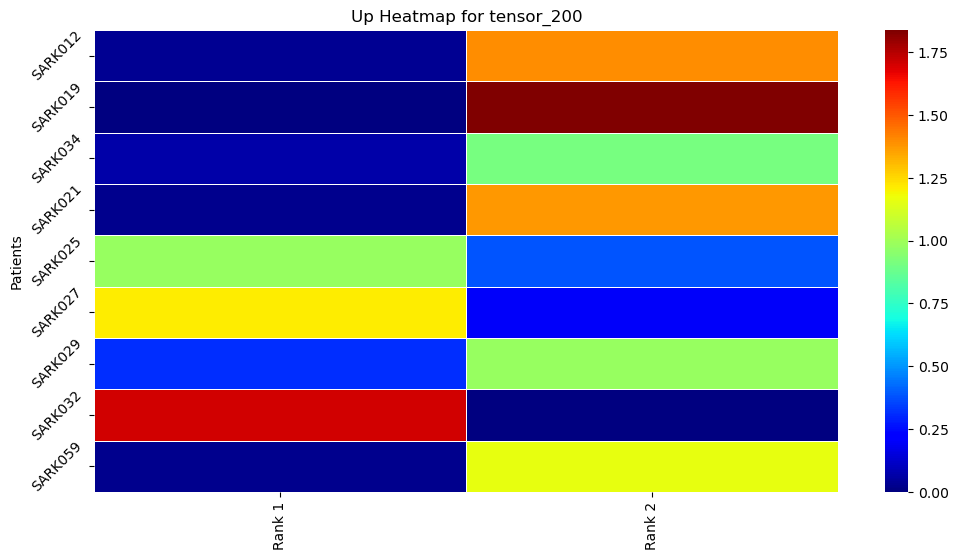

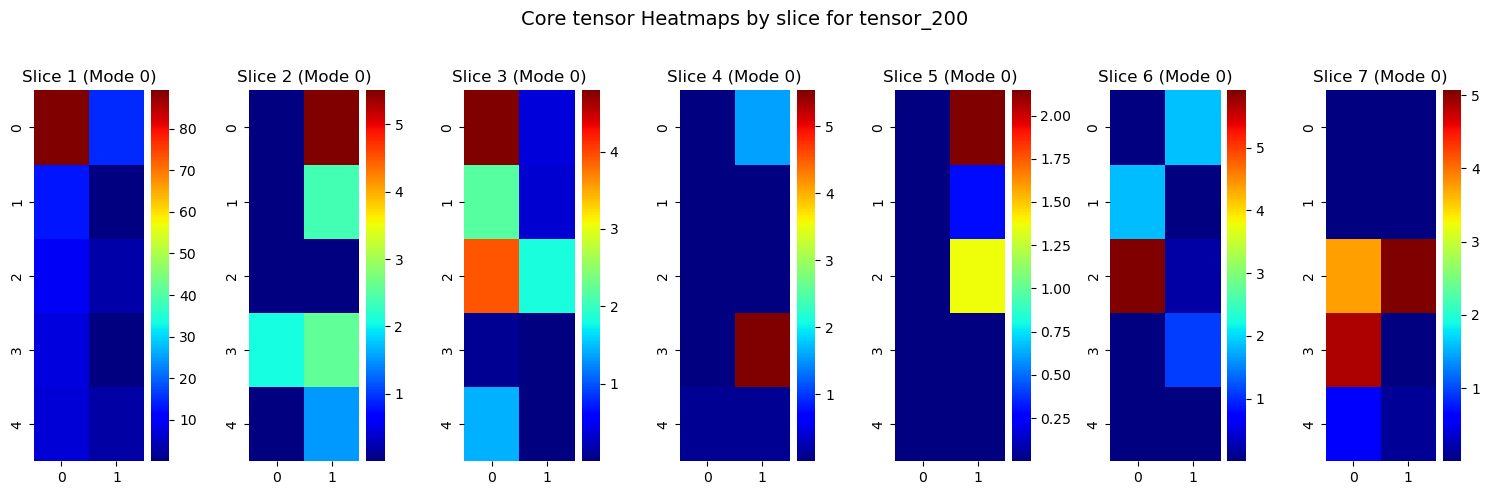

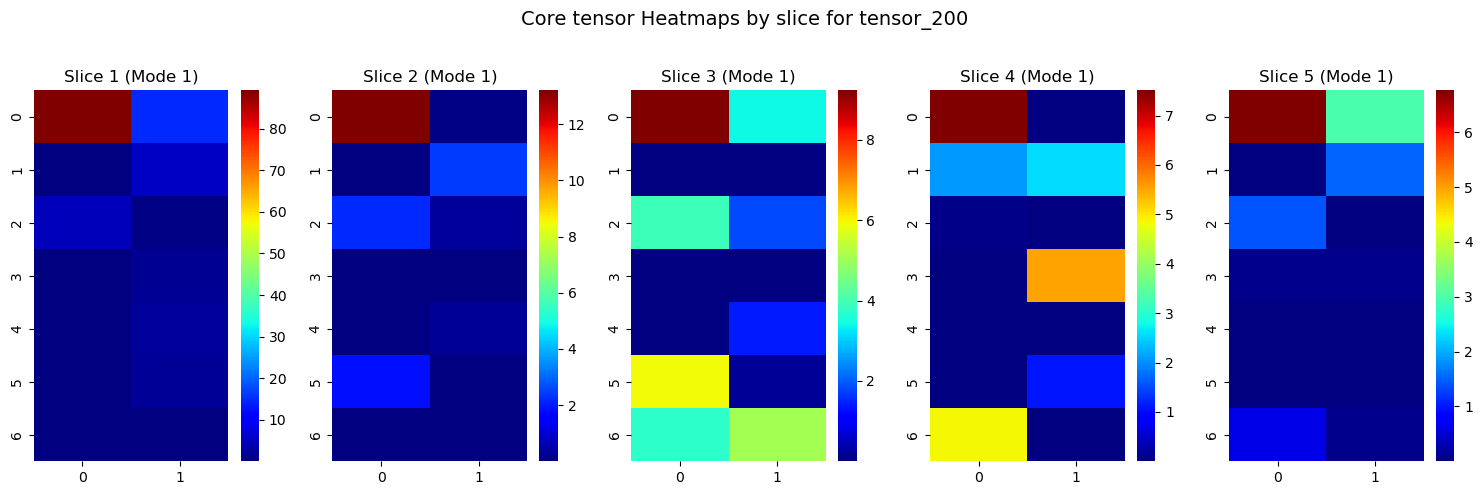

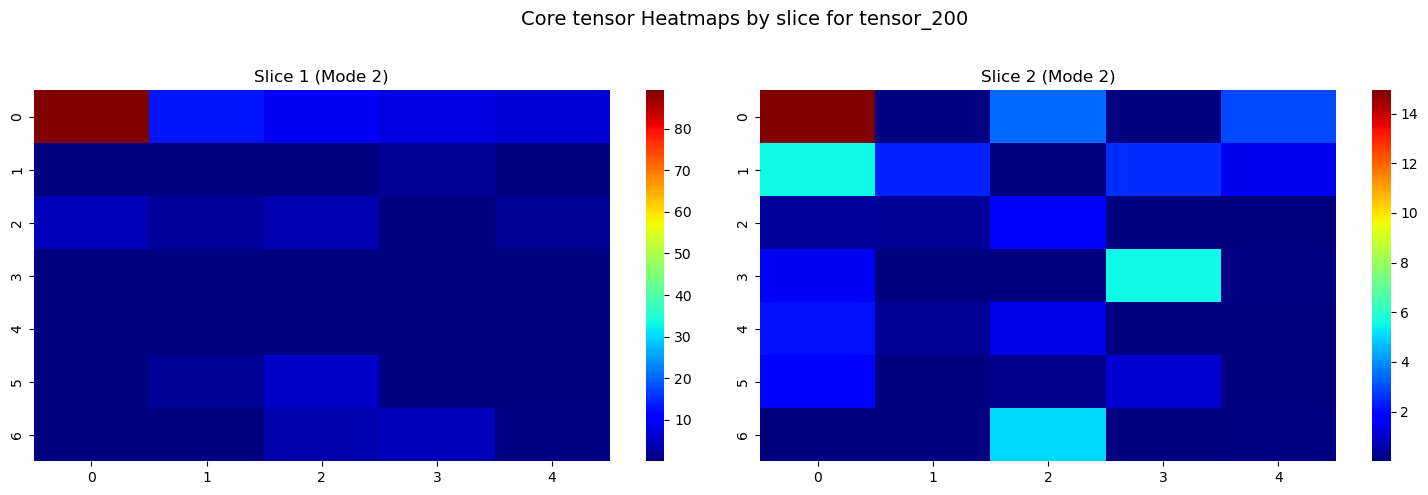

        Index        Weight      Fraction  Sign
0   (1, 1, 1)  8.925615e+01  9.036702e-01   1.0
1   (1, 1, 2)  1.493317e+01  2.529517e-02   1.0
2   (1, 2, 1)  1.320825e+01  1.978903e-02   1.0
4   (1, 3, 1)  9.230232e+00  9.664043e-03   1.0
6   (1, 4, 1)  7.511251e+00  6.399678e-03   1.0
8   (1, 5, 1)  6.762421e+00  5.187260e-03   1.0
54  (6, 3, 1)  5.913202e+00  3.966240e-03   1.0
37  (4, 4, 2)  5.533015e+00  3.472621e-03   1.0
11  (2, 1, 2)  5.502530e+00  3.434460e-03   1.0
65  (7, 3, 2)  5.065715e+00  2.910818e-03   1.0
66  (7, 4, 1)  4.850622e+00  2.668877e-03   1.0
20  (3, 1, 1)  4.790257e+00  2.602862e-03   1.0
24  (3, 3, 1)  3.913305e+00  1.737085e-03   1.0
64  (7, 3, 1)  3.741326e+00  1.587760e-03   1.0
5   (1, 3, 2)  3.400543e+00  1.311687e-03   1.0
9   (1, 5, 2)  2.972075e+00  1.001967e-03   1.0
17  (2, 4, 2)  2.565436e+00  7.465451e-04   1.0
13  (2, 2, 2)  2.376616e+00  6.406955e-04   1.0
22  (3, 2, 1)  2.189041e+00  5.435524e-04   1.0
41  (5, 1, 2)  2.145957e+00  5.223667e-0

In [146]:
i=2 #tensor_200
td_dic = tucker_results[tensor_names[i]]
pat_list = ['SARK012', 'SARK019', 'SARK034', 'SARK021', 'SARK025', 
            'SARK027', 'SARK029', 'SARK032', 'SARK059']
decomp_visualizations(td_dic,tensor_names[i], pat_list=pat_list)

##### tensor_300

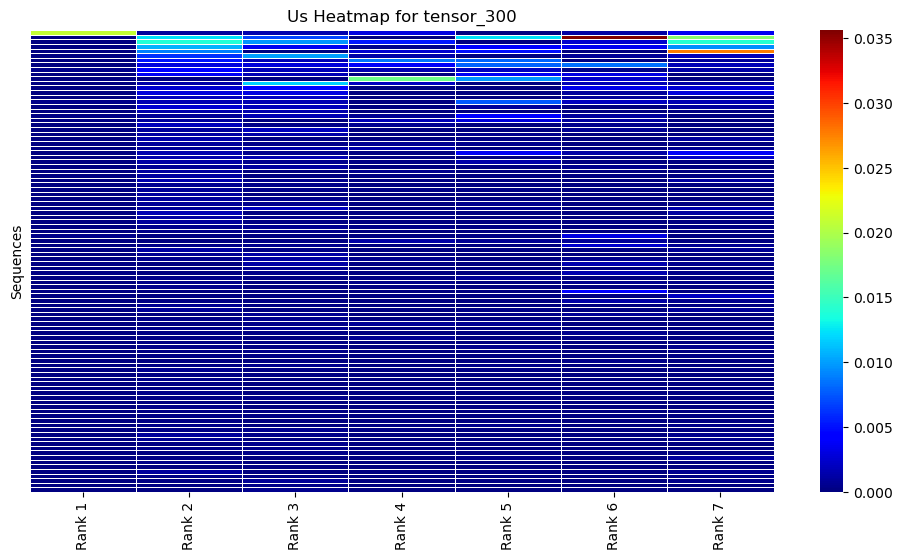

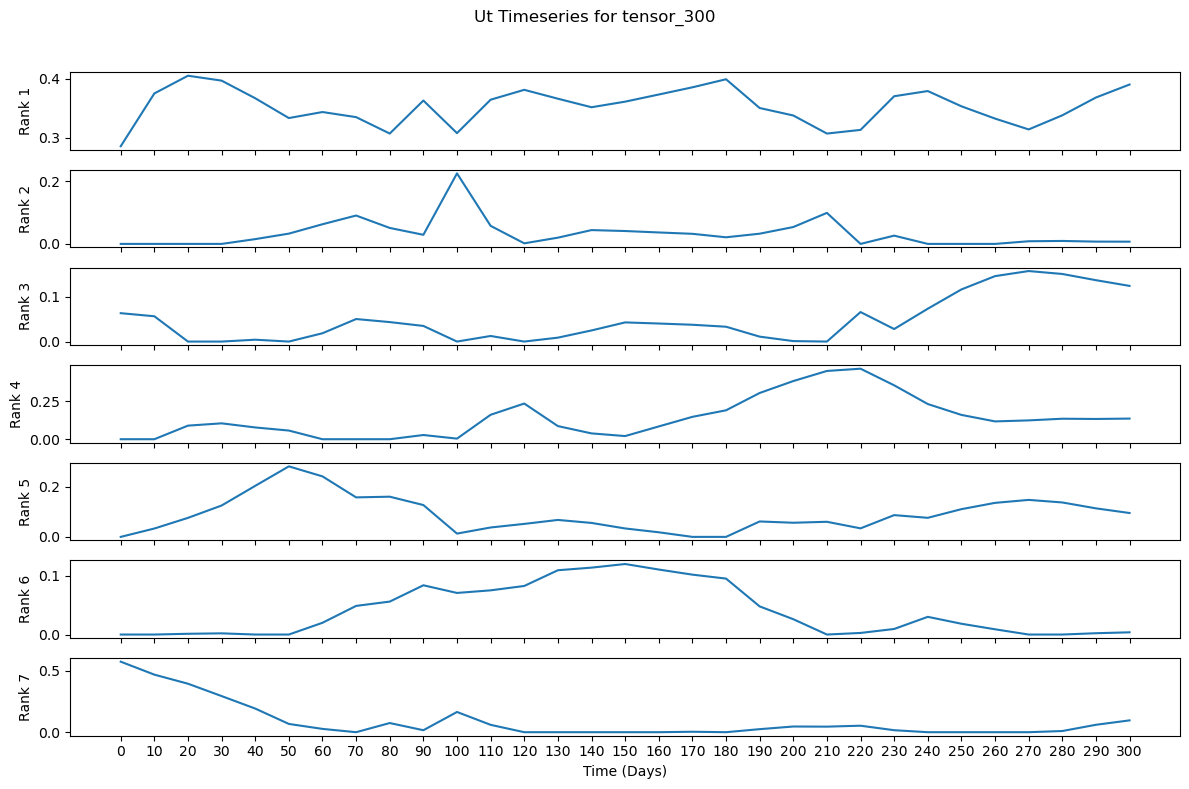

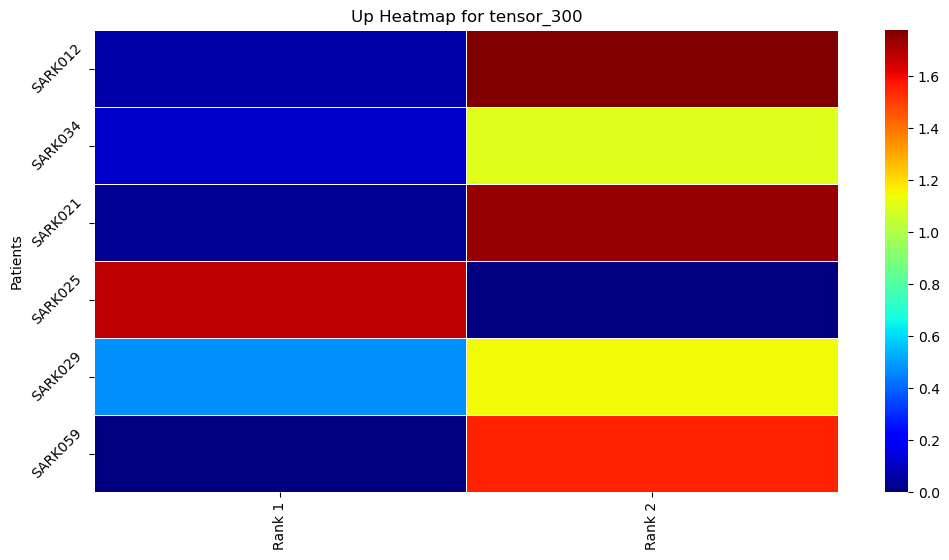

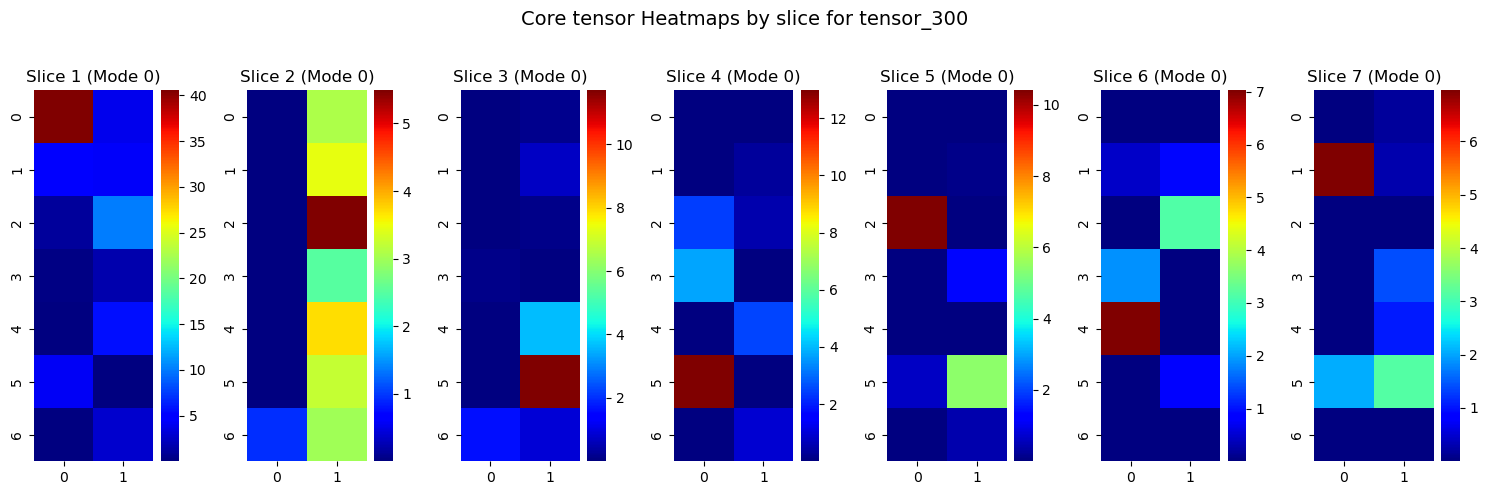

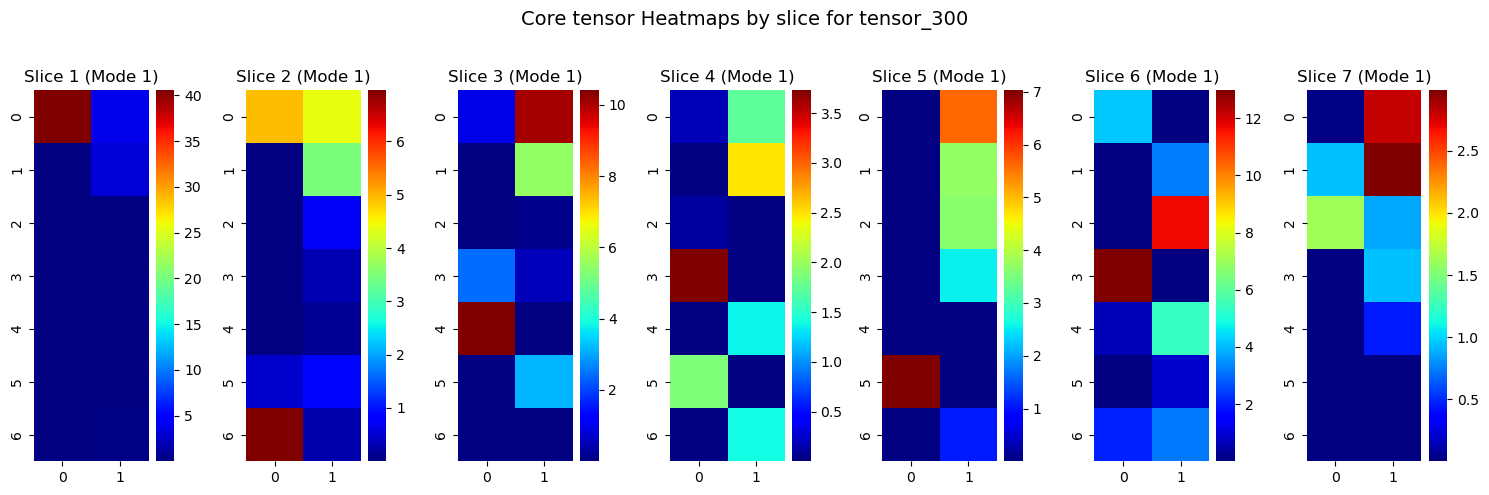

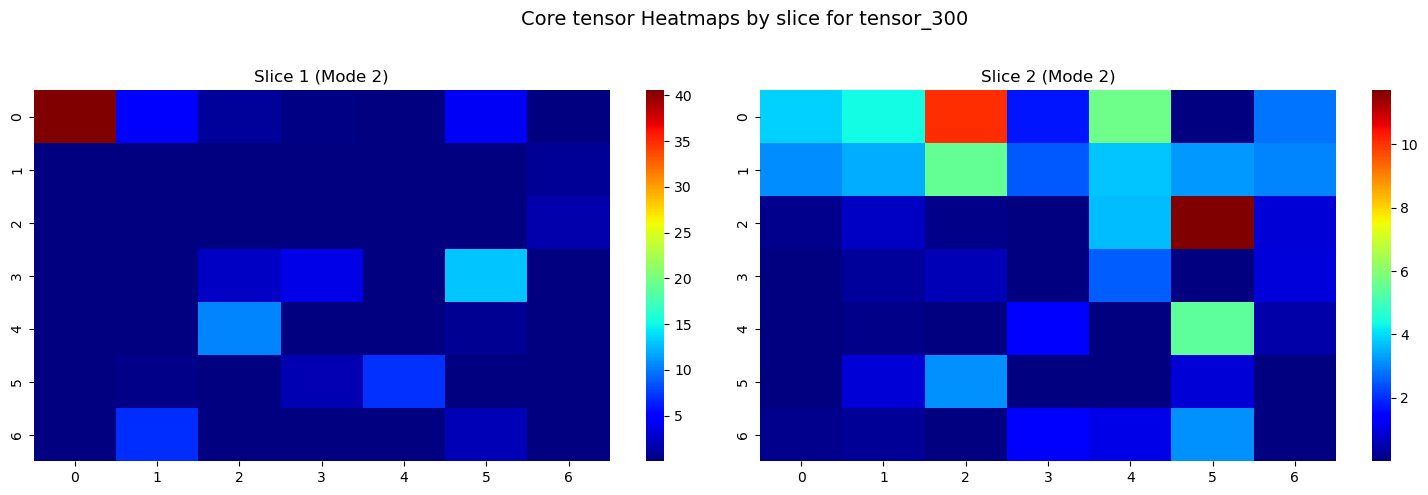

        Index        Weight      Fraction  Sign
0   (1, 1, 1)  4.055267e+01  6.380555e-01   1.0
52  (4, 6, 1)  1.297649e+01  6.533316e-02   1.0
39  (3, 6, 2)  1.169856e+01  5.309877e-02   1.0
60  (5, 3, 1)  1.040811e+01  4.203041e-02   1.0
5   (1, 3, 2)  1.006030e+01  3.926821e-02   1.0
78  (6, 5, 1)  7.029113e+00  1.916993e-02   1.0
86  (7, 2, 1)  6.959733e+00  1.879337e-02   1.0
9   (1, 5, 2)  5.621151e+00  1.225942e-02   1.0
19  (2, 3, 2)  5.490075e+00  1.169435e-02   1.0
67  (5, 6, 2)  5.418623e+00  1.139193e-02   1.0
2   (1, 2, 1)  4.936025e+00  9.453098e-03   1.0
3   (1, 2, 2)  4.386324e+00  7.464847e-03   1.0
10  (1, 6, 1)  4.199158e+00  6.841385e-03   1.0
1   (1, 1, 2)  3.862552e+00  5.788528e-03   1.0
48  (4, 4, 1)  3.729106e+00  5.395466e-03   1.0
23  (2, 5, 2)  3.709779e+00  5.339685e-03   1.0
37  (3, 5, 2)  3.645298e+00  5.155674e-03   1.0
17  (2, 2, 2)  3.459001e+00  4.642167e-03   1.0
25  (2, 6, 2)  3.227332e+00  4.041168e-03   1.0
95  (7, 6, 2)  3.152264e+00  3.855357e-0

In [147]:
i=3 #tensor_300
td_dic = tucker_results[tensor_names[i]]
pat_list = ['SARK012', 'SARK034', 'SARK021', 'SARK025', 
            'SARK029', 'SARK059']
decomp_visualizations(td_dic,tensor_names[i], pat_list=pat_list)

### Clustering

### Classification